# 📡🌍 BiDS'25 — EO4EU Tutorial

## EO4EU Objectives

AI-augmented ecosystem for Earth Observation data accessibility with Extended reality User Interfaces for Service and data exploitation, or EO4EU, is a European Commission funded innovation project which aims at creating an advanced platform for searching, discovering, processing and analyzing EO data.
The platform leverages machine learning to support handling of the characteristically-large volume of EO data as well as a combination of cloud computing infrastructure and pre-exascale high-performance computing to manage processing workloads.​

The EO4EU Platform allows for searching, discovering processing and analyzing EO data and is based on a series of innovative technologies which allow to:

- Access EO data from different sources (e.g., Copernicus, Galileo, ECMWF)​.
- Support a sophisticated representation of data through a semantic-enhanced Knowledge Graph​.
- Use Machine Learning from marketplace to EO data processing​.
- Visualize EO data through easy-to-use graphical interfaces and Extended Reality applications​.
---
## EO4EU Architecture

![EO4EU Architecture](./assets/eo4eu-architecture.png)

---
## EO4EU Infrastructure

![EO4EU Infra](./assets/eo4eu-infra.png)

---
Check out the content pages bundled with this sample book to see more.

## EO4EU Use Cases

- *EO for Personalized Health Care*: to expand mobile allergy and airbrone hazards forecasting.
- *Food Security*: to improve the adaptability of food production using EO4EU for live climate data tracking and analysis.
- *Soil Erosion*: to integrate rainfall datasets through EO4EU to assess soil suspectibility to water erosion.
- *Civil Protection*: to improve disaster and calamity prevention and response using EO datasets.
- *Ocean Monitoring*: to optimize shipping industry travel time across different oceans considering live weather data.
- *Forest Ecosystem*: to improve forest productivity using EO4EU to simulate water, energy and carbon fluxes.
- *Environmental Pests*: to assess and predict the impact of locust plague.

> For more information visit [EO4EU website](https://eo4eu.eu)


# 📡🌍 BiDS'25 — Lightweight Masked Autoencoder Architecture for Earth Observation  

This notebook explores a **metadata-aware lightweight Mixutre-of-Experts Masked Autoencoder (MOE-MAE) architecture** for Earth Observation (EO) data.  

---

## 📑 Contents  

### 1. Overview  
- **Lightweight metadata-aware MOE-MAE**  
- Pretraining strategy  
- Comparison with larger MAE architectures  

---

### 2. Embedding Exploration  
- Generate embeddings of the **EuroSAT-Landsat** dataset using **MoE-MAE**  
- Visualize the learned feature space with **t-SNE**  
- Highlight different **sample categories** from *EuroSAT-LS* 
---

### 3. Expert Specialization  
- Investigate how individual **experts specialize**  
---

### 4. Search by Image  
- Perform **image retrieval** using embeddings  
- Use **ChromaDB** for efficient similarity search  

---


## 1) Overview

### Model Design
- **Architecture**: Compact Vision Transformer with Mixture-of-Experts (MoE).
- **Parameters**: ~2.5M total (encoder ~2.3M).
- **Core ideas**:
  - **Sparse expert routing**: Tokens routed to a small subset of SwiGLU experts using NoisyTop-k gating.
  - **Geo-temporal conditioning**: Latitude, longitude, week-of-year, and hour-of-day encoded as sinusoidal (sin, cos) pairs → projected into embedding space → added as metadata tokens.
  - **Grouped Query Attention (GQA)**: Efficient multi-head attention variant.
  - **Lightweight decoder**: Two MoE transformer layers with reduced hidden size.

![MoE-MAE Architecture](assets/moe_mae.png)

$$
\begin{aligned}
\textbf{Inputs:}\quad 
& \texttt{imgs} \in \mathbb{R}^{B\times C\times H\times W},\\
& \texttt{meta\_week},\ \texttt{meta\_hour},\ \texttt{meta\_lat},\ \texttt{meta\_lon} \in \mathbb{R}^{B\times 2}\ \ (\text{sin/cos pairs})\\[6pt]
%
\textbf{Encoder (mLiT):}\quad 
& \text{patches} \leftarrow \mathrm{ConvPatchify}(\texttt{imgs}) \in \mathbb{R}^{B\times N\times \mathrm{emb}}\\
& (\text{ids\_keep},\ \text{ids\_restore},\ \text{mask}) \leftarrow \mathrm{RandomMask}(N,\ \text{ratio})\\
& \text{kept} \leftarrow \mathrm{Gather}(\text{patches},\ \text{ids\_keep}) \in \mathbb{R}^{B\times N_{\text{keep}}\times \mathrm{emb}}\\
& \text{meta\_tokens} \leftarrow [W(\texttt{meta\_week}),\ H(\texttt{meta\_hour}),\ \Phi(\texttt{meta\_lat}),\ \Lambda(\texttt{meta\_lon})] \in \mathbb{R}^{B\times 4 \times \mathrm{emb}}\\
& \text{cls} \leftarrow \mathrm{expand}(\mathrm{CLS},\ B,1,\mathrm{emb})\\
& \text{enc\_in} \leftarrow \mathrm{Concat}(\text{meta\_tokens},\ \text{cls},\ \text{kept})\ \in\ \mathbb{R}^{B\times(M+1+N_{\text{keep}})\times \mathrm{emb}},\quad M=4\\[3pt]
& \text{pos\_meta\_cls} \leftarrow \mathrm{POS}[:,\ 0{:}(M{+}1),:]\ \in\ \mathbb{R}^{1\times(M+1)\times \mathrm{emb}}\\
& \text{pos\_patches} \leftarrow \mathrm{POS}[:,\ (M{+}1){:}(M{+}1{+}N),:]\ \in\ \mathbb{R}^{1\times N\times \mathrm{emb}}\\
& \text{pos\_kept} \leftarrow \mathrm{Gather}(\mathrm{expand}(\text{pos\_patches},B),\ \text{ids\_keep})\ \in\ \mathbb{R}^{B\times N_{\text{keep}}\times \mathrm{emb}}\\
& \text{enc\_in} \leftarrow \text{enc\_in}\ +\ \mathrm{Concat}(\mathrm{expand}(\text{pos\_meta\_cls},B),\ \text{pos\_kept})\\[3pt]
& x \leftarrow \text{enc\_in},\quad \text{total\_moe\_loss} \leftarrow 0\\
& \textbf{for each } \ell \in \text{encoder\_layers:}\\
& \qquad (x,\ \ell_{\text{aux}}) \leftarrow \ell(x)\quad (\text{MoE layer})\\
& \qquad \text{total\_moe\_loss} \leftarrow \text{total\_moe\_loss} + \ell_{\text{aux}}\\
& x \leftarrow \mathrm{LayerNorm}(x)\\
& \text{enc\_meta} \leftarrow x[:,\ 0{:}(M{+}1),:]\ \in\ \mathbb{R}^{B\times(M+1)\times \mathrm{emb}}\\
& \text{enc\_patches} \leftarrow x[:,\ (M{+}1):,:]\ \in\ \mathbb{R}^{B\times N_{\text{keep}}\times \mathrm{emb}}\\[8pt]
%
\textbf{Decoder (mmLiT):}\quad
& \text{meta\_dec} \leftarrow \mathrm{Linear}(\text{enc\_meta}) \in \mathbb{R}^{B\times(M+1)\times \mathrm{dec}}\\
& \text{vis\_dec} \leftarrow \mathrm{Linear}(\text{enc\_patches}) \in \mathbb{R}^{B\times N_{\text{keep}}\times \mathrm{dec}}\\
& \text{num\_mask} \leftarrow N - N_{\text{keep}}\\
& \text{mask\_tok} \leftarrow \mathrm{expand}(\mathrm{MASK},\ B,\ \text{num\_mask},\ \mathrm{dec})\\
& \text{dec\_all} \leftarrow \mathrm{Concat}(\text{vis\_dec},\ \text{mask\_tok}) \in \mathbb{R}^{B\times N\times \mathrm{dec}}\\
& \text{dec\_restored} \leftarrow \mathrm{Gather}(\text{dec\_all},\ \text{ids\_restore})\\
& \text{dec\_seq} \leftarrow \mathrm{Concat}(\text{meta\_dec},\ \text{dec\_restored}) \in \mathbb{R}^{B\times(M+1+N)\times \mathrm{dec}}\\
& \text{dec\_pos} \leftarrow \mathrm{Concat}(\mathrm{Zeros}(1,M{+}1,\mathrm{dec}),\ \mathrm{DEC\_POS}) \in \mathbb{R}^{1\times(M+1+N)\times \mathrm{dec}}\\
& \text{dec\_seq} \leftarrow \text{dec\_seq} + \text{dec\_pos}[:,\ 0{:}(M{+}1{+}N),:]\\
& y \leftarrow \text{dec\_seq}\\
& \textbf{for each } \ell \in \text{decoder\_layers:}\\
& \qquad (y,\ \_) \leftarrow \ell(y)\quad (\text{MoE layer})\\
& y \leftarrow \mathrm{LayerNorm}(y)\\
& \text{pred} \leftarrow \mathrm{Linear}\big(y[:,\ (M{+}1):,:]\big)\ \in\ \mathbb{R}^{B\times N\times (\text{patch\_area}\cdot C)}\\[8pt]
\end{aligned}
$$

### Pretraining Objective
The model is trained using a self-supervised reconstruction-based objective:

1. **Masked patch reconstruction**  
   Loss applied to masked patches only.

   $$
   L_{\text{masked}} = \frac{1}{|M|} \sum_{i \in M} \| \hat{x}_i - x_i \|^2
   $$
3. **Auxiliary reconstruction on visible patches**  
   $$
   L_{\text{unmasked}} = \frac{1}{|V|} \sum_{i \in V} \| \hat{x}_i - x_i \|^2
   $$

4. **MoE regularization (load balancing)**  
   Ensures balanced expert usage via coefficient-of-variation penalties.

**Final loss function:**
$$
L = L_{\text{masked}} + \alpha L_{\text{unmasked}} + \beta L_{\text{MoE}}
$$


### Training Setup
- **Dataset**: BigEarthNet-Landsat (BEN-LS) Training Split, ~320k samples, 7 spectral bands.
- **Masking ratio**: 75%.
- **Epochs**: 500.
- **Batch size**: 128.
- **Optimizer**: AdamW.
- **Learning rate schedule**: 
  - Base LR = 3e-4.  
  - Warmup for 5% of epochs.  
  - Cosine decay to 0.  
- **Weight decay**: 0.05.


### Install requirements

In [ ]:
# ! pip install geo_moe_mae/requirements.txt
! pip install plotly==6.2.0 chromadb==1.0.21

In [ ]:
! git lfs install

### Download EuroSAT-LANDSAT dataset from HuggingFace

In [2]:
! git clone https://huggingface.co/datasets/isaaccorley/eurosat-l

fatal: destination path 'eurosat-l' already exists and is not an empty directory.


In [ ]:
! bsdtar -xf eurosat-l/eurosat-l.zip -C eurosat-l

### Clone Metadata-Aware MOE-MAE from Github

In [3]:
! git clone https://github.com/AlbughdadiM/geo-moe-mae.git

Cloning into 'geo-moe-mae'...
remote: Enumerating objects: 483, done.
remote: Counting objects: 100% (483/483), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 483 (delta 216), reused 480 (delta 213), pack-reused 0 (from 0)
Receiving objects: 100% (483/483), 33.99 MiB | 7.94 MiB/s, done.
Resolving deltas: 100% (216/216), done.


In [4]:
! mv geo-moe-mae geo_moe_mae

### Get EuroSAT-LANDSAT test split embeddings

In [9]:
! wget https://object-store.os-api.cci1.ecmwf.int/MoBucket/BiDS2025/x_y_test_eurosat_ls.npz

--2025-09-15 21:07:35--  https://object-store.os-api.cci1.ecmwf.int/MoBucket/BiDS2025/x_y_test_eurosat_ls.npz
Resolving object-store.os-api.cci1.ecmwf.int (object-store.os-api.cci1.ecmwf.int)... 64:ff9b::889c:8003, 136.156.128.3
Connecting to object-store.os-api.cci1.ecmwf.int (object-store.os-api.cci1.ecmwf.int)|64:ff9b::889c:8003|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326700510 (312M) [application/zip]
Saving to: ‘x_y_test_eurosat_ls.npz’

x_y_test_eurosat_ls 100%[===================>] 311,57M  9,99MB/s    in 30s     

2025-09-15 21:08:05 (10,5 MB/s) - ‘x_y_test_eurosat_ls.npz’ saved [326700510/326700510]



### Import libraries

In [1]:
import sys
sys.path.append("./geo_moe_mae")
import os
import shutil

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import math
from torch.utils.data import Subset
import chromadb
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from models.moe_mae import MOEMAE, build_model
from datasets.eurosat import EuroSATDatasetLS
from utils.data_config import BigEarthNetInfo
from utils.data_utils import load_model
from transformation.transformer import ToFloat, ZScoreNormalize
from utils.analysis_utils import layer_report_simple

### Get accelration device if available

In [3]:
device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps" if torch.backends.mps.is_available() else "cpu"
    )
print(f"Using device: {device}")

Using device: mps


### Initialize Metadata-Aware MoE-MAE model

In [4]:
model_size = "S"
img_size = 40
patch_size = 4
in_channels = 7
checkpoint_path = "./geo_moe_mae/weights/moe_mae_bigearthnet_ls/pretrained_S_best.pth"
encoder = build_model(
        size=model_size,
        img_size=img_size,
        patch_size=patch_size,
        in_chans=in_channels,
    )
model = MOEMAE(encoder).to(device)
model = load_model(model,checkpoint_path,device)
encoder = model.encoder
encoder.eval();

### Set data path

In [7]:
data_txt_train = "./eurosat-l/eurosat-train.txt"
data_txt_val = "./eurosat-l/eurosat-val.txt"
data_txt_test = "./eurosat-l/eurosat-test.txt"
data_path = "./eurosat-l/eurosat-l"
save_path = "./eurosat-l"
label_class = ['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

## 2) Embedding Exploration using t-SNE

### Apply t-SNE and visualize with the dataset labels

In [4]:
npz_path_test = "x_y_test_eurosat_ls.npz" 
test_embeddings = np.load(npz_path_test)

In [5]:
x_test, y_test= (
    test_embeddings["x_test"],
    test_embeddings["y_test"]
    )

In [27]:
cls_token = x_test[:, 576:720]
other_tokens = x_test[:, 720:]
labels = np.argmax(y_test, axis=1)
print (cls_token.shape)
print (other_tokens.shape)
print (x_test.shape)
print (labels.shape)

(5400, 144)
(5400, 14400)
(5400, 15120)
(5400,)


### t-SNE on all tokens

In [28]:
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
emb_3d = tsne.fit_transform(x_test)

### t-SNE on all tokens other than metadata and cls token

In [29]:
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
emb_3d_other = tsne.fit_transform(other_tokens)

### t-SNE on CLS tokens

In [30]:
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
emb_3d_cls = tsne.fit_transform(cls_token)

### t-SNE on metadata tokens and cls tokens

In [31]:
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
emb_3d_cls_meta = tsne.fit_transform(x_test[:,0:720])

### Plot the results

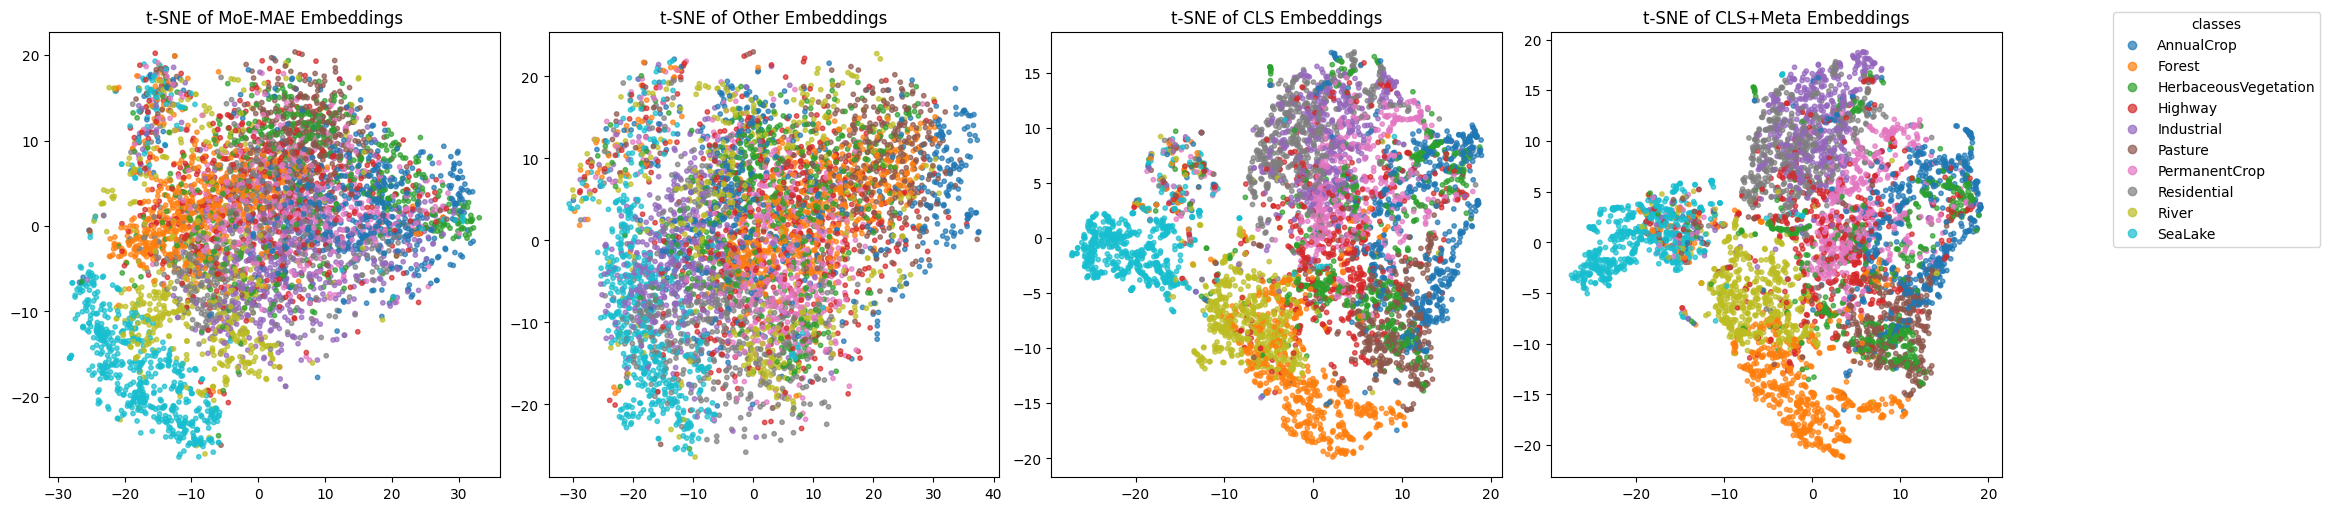

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5), constrained_layout=True)

embeddings = [emb_3d, emb_3d_other, emb_3d_cls, emb_3d_cls_meta]
titles = ["t-SNE of MoE-MAE Embeddings",
          "t-SNE of Other Embeddings",
          "t-SNE of CLS Embeddings",
          "t-SNE of CLS+Meta Embeddings"]

for ax, emb, title in zip(axes, embeddings, titles):
    scatter = ax.scatter(
        emb[:, 0], emb[:, 1],
        c=labels, cmap="tab10", s=10, alpha=0.7
    )
    ax.set_title(title)

# Create a single legend for all subplots
handles, cls_labels = scatter.legend_elements(num=len(label_class))
fig.legend(handles, label_class, title="classes", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.show()


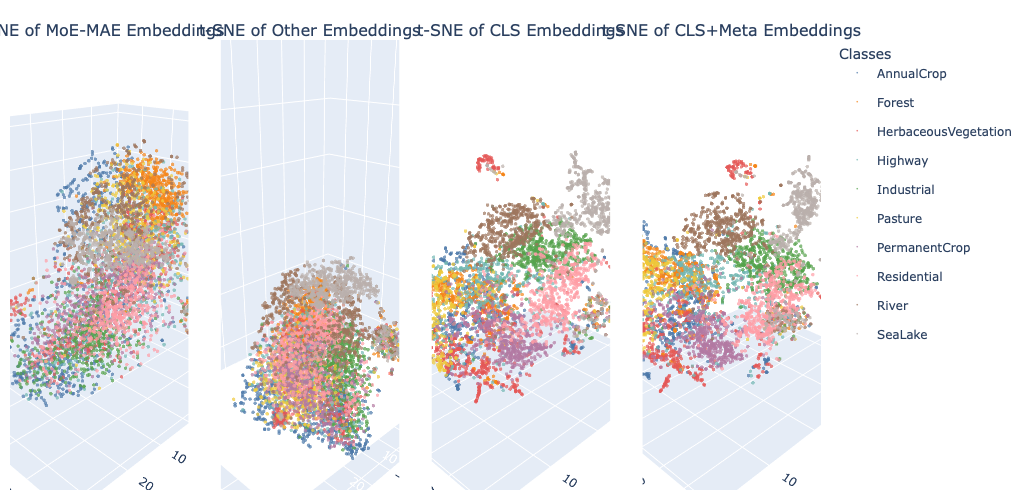

In [33]:
def to3d(arr):
    arr = np.asarray(arr)
    if arr.shape[1] == 3:
        return arr
    elif arr.shape[1] == 2:  # pad with zeros
        return np.hstack([arr, np.zeros((arr.shape[0], 1))])
    else:
        raise ValueError(f"Expected [N,2] or [N,3], got {arr.shape}")

embeddings = [emb_3d, emb_3d_other, emb_3d_cls, emb_3d_cls_meta]
titles = ["t-SNE of MoE-MAE Embeddings",
          "t-SNE of Other Embeddings",
          "t-SNE of CLS Embeddings",
          "t-SNE of CLS+Meta Embeddings"]

embeddings = [to3d(e) for e in embeddings]

palette = px.colors.qualitative.T10
color_map = {cls: palette[i % len(palette)] for i, cls in enumerate(label_class)}

fig = make_subplots(
    rows=1, cols=4,
    specs=[[{"type":"scene"}]*4],
    subplot_titles=titles,
    horizontal_spacing=0.04
)
for col, (emb, title) in enumerate(zip(embeddings, titles), start=1):
    for i in range (len(label_class)):
        mask = (labels == i)
        pts = emb[mask]
        if pts.size == 0:
            continue
        fig.add_trace(
            go.Scatter3d(
                x=pts[:, 0], y=pts[:, 1], z=pts[:, 2],
                mode="markers",
                name=label_class[i],
                legendgroup=label_class[i],
                showlegend=(col == 1),  # show legend only once
                marker=dict(size=2, opacity=0.7, color=color_map[label_class[i]]),
                hovertemplate=(
                    f"<b>{title}</b><br>x=%{{x:.3f}}<br>y=%{{y:.3f}}<br>z=%{{z:.3f}}<br>"
                    f"class={label_class[i]}<extra></extra>"
                )
            ),
            row=1, col=col
        )

fig.update_layout(
    height=500, width=1400,
    margin=dict(l=10, r=10, t=40, b=10),
    legend=dict(title="Classes", yanchor="top", y=1, xanchor="left", x=1.02)
)

for i in range(1, 5):
    fig.update_scenes(aspectmode="data", camera=dict(eye=dict(x=1.35, y=1.35, z=0.8)), row=1, col=i)

fig.show()


#### Linear probe performance on EuroSAT-LS Test Split.
| Embedding         | OA % | Precision (macro) | Recall (macro) | F1 (macro) |
|-------------------|------|-------------------|----------------|------------|
| CLS token         | 78.4 | 0.781             | 0.779          | 0.777      |
| All tokens        | **84.2** | **0.845**     | **0.838**      | **0.839**  |
| All tokens (Avg.) | 74.3 | 0.739             | 0.737          | 0.731      |


## 3) Expert Specialization

### Data transformation, datasets, and dataloaders

In [8]:
bigearth_transforms = transforms.Compose(
        [
            transforms.Resize((40, 40)),
            ToFloat(),
            ZScoreNormalize(
                BigEarthNetInfo.STATISTICS["mean"],
                BigEarthNetInfo.STATISTICS["std"],
            ),
        ]
    )


test_dataset = EuroSATDatasetLS(
        root_dir = data_path,
        split_file = data_txt_test,
        transform=bigearth_transforms,
        return_one_hot=True,
        strict=False,
    )

test_dataloader = DataLoader(
        test_dataset,
        batch_size=16,
        persistent_workers=False,
        prefetch_factor=4,
        num_workers=4,
        shuffle=False,
    )

## Visualize experts specialities

In [35]:
data_iter = iter(test_dataloader)

In [48]:
imgs, labels = next(data_iter)

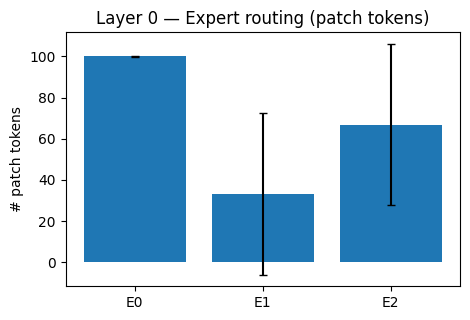

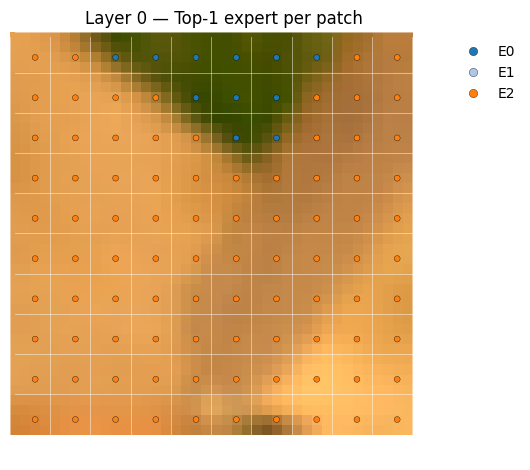

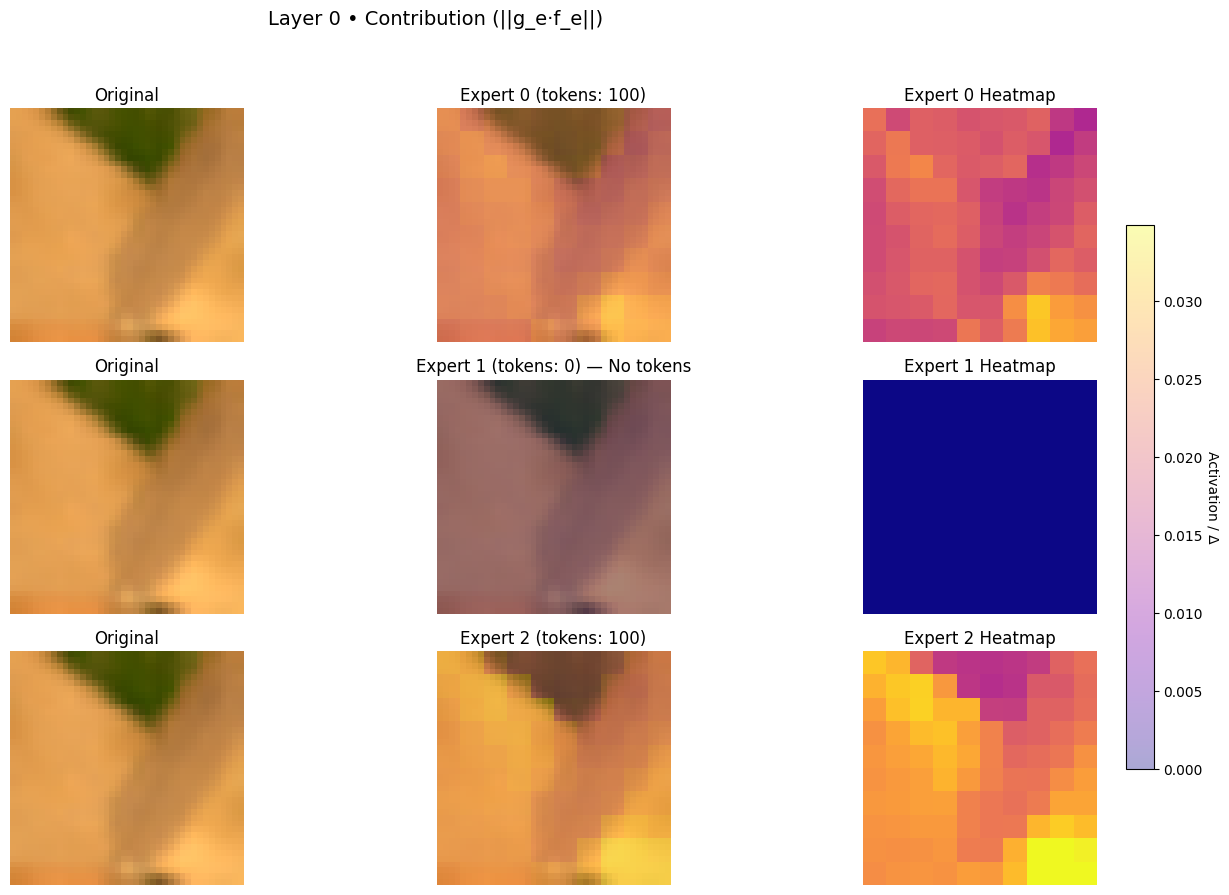

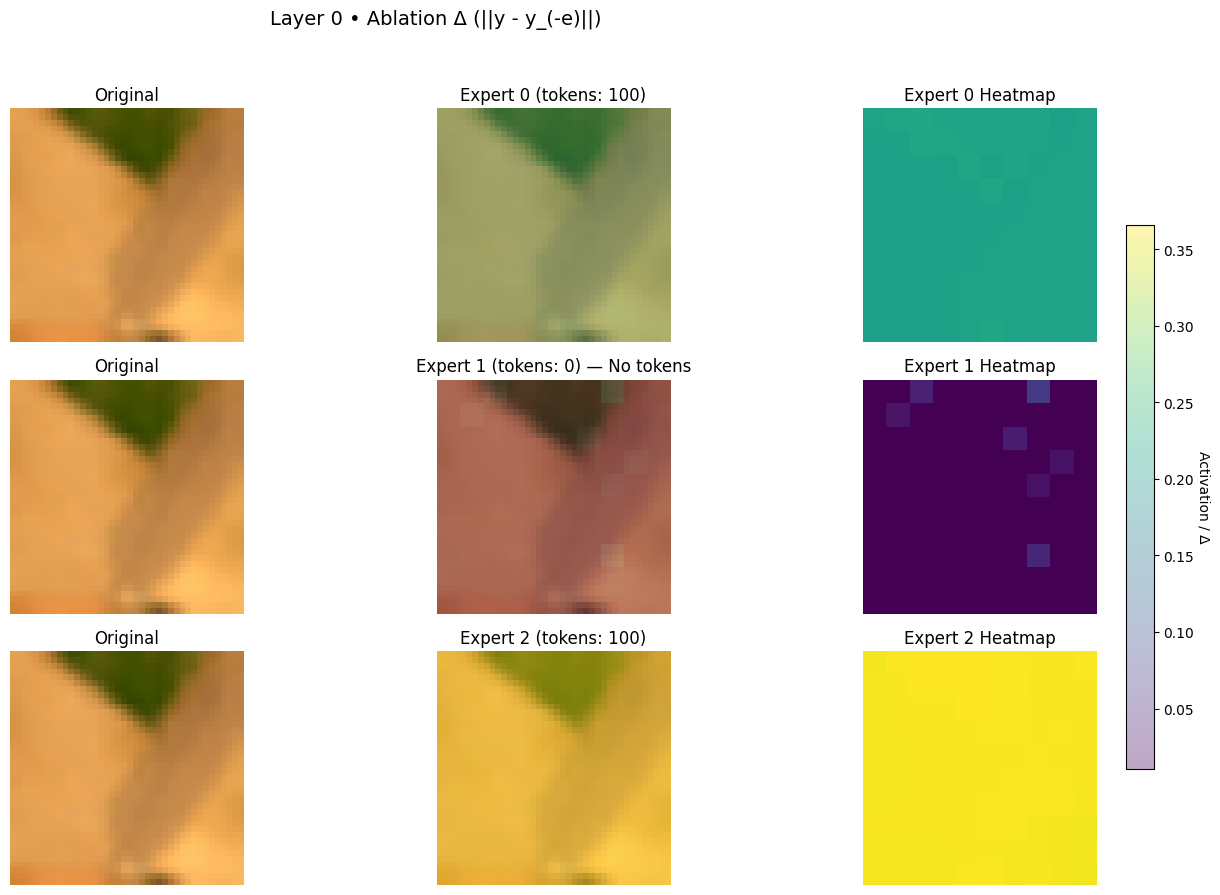

{'num_experts': 3,
 'usage_image': array([100,   0, 100]),
 'moe_loss': 0.053511884063482285}

In [50]:
# Pick an image and a layer to inspect
image_index = 6
layer_index = 0
layer_report_simple(
    model,
    imgs,
    image_index=image_index,
    layer_index=layer_index,
    max_values=np.array([65454.0, 65454.0, 65330.308]), # From BigEartInfo STATS
    rgb_bands=(3,2,1),
    device=device
)

## 3) Image Search with ChromaDB

In [9]:
MEAN_ARR = np.array([9405.194, 9649.677, 10425.686, 10444.589, 16067.627, 12699.184, 10596.475])
STD_ARR = np.array([6016.344, 6095.472, 5839.462, 6068.493, 6271.440, 4256.046, 3130.776])
MAX_ARR = np.array( [63979.918, 65330.308, 65454.0, 65454.0, 65454.0, 65454.004, 65454.004])

X = x_test
X = X.reshape(X.shape[0],105,144)
Y = y_test
Y = np.argmax(Y,axis=1)
dataset = test_dataset
assert X.ndim == 3 and X.shape[1:] == (105,144)
assert len(Y) == X.shape[0]

N = X.shape[0]
np.random.seed(42)
perm = np.random.permutation(N)
X = X[perm] 
Y = Y[perm] 
dataset = Subset(dataset, perm)
# 1) Flatten + L2-normalize for cosine
Xf = X.reshape(N, -1)
Xf = Xf / (np.linalg.norm(Xf, axis=1, keepdims=True) + 1e-12)

ids = [f"img_{i}" for i in range(N)]
metas = [{"label": int(Y[i]), "index": int(i)} for i in range(N)]

# 2) Chroma index (cosine)
if os.path.exists("./chroma_demo"):
    shutil.rmtree("./chroma_demo") 
client = chromadb.PersistentClient(path="./chroma_demo")  # change path if you like
col = client.get_or_create_collection(name="image_embeddings_demo", metadata={"hnsw:space": "cosine"})
try:
    col.delete(where={})   # clear all to avoid duplicates on re-runs
except Exception:
    pass

col.add(
    ids=ids,
    embeddings=Xf.tolist(),
    metadatas=metas
)


In [10]:
def _query(vec_flat_l2norm: np.ndarray, top_k: int = 5):
    res = col.query(
        query_embeddings=[vec_flat_l2norm.tolist()],
        n_results=top_k,
        include=["metadatas","distances"]
    )
    out = []
    for i in range(len(res["ids"][0])):
        out.append({
            "rank": i+1,
            "id": res["ids"][0][i],
            "distance": float(res["distances"][0][i]),   # cosine distance (smaller is better)
            "label": int(res["metadatas"][0][i]["label"]),
            "index": int(res["metadatas"][0][i]["index"]),
        })
    return out

def search_by_idx(i: int, top_k: int = 5):
    v = Xf[i].astype(np.float32)
    return _query(v, top_k)

def search_by_embedding(emb_105x144, top_k: int = 5):
    v = torch.as_tensor(emb_105x144).reshape(1, -1).float()
    v = v / (v.norm(dim=1, keepdim=True) + 1e-12)
    return _query(v[0].cpu().numpy().astype(np.float32), top_k)

def _to_numpy_img(sample,mean_t = MEAN_ARR,std_t = STD_ARR,max_t = MAX_ARR):
    img = sample[0]
    label = sample[1]
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().numpy()
    img = np.transpose(img, (1,2,0))  # CHW->HWC
    img = img * std_t + mean_t
    img = img / max_t
    img = np.clip(img, 0, 1)
    lo, hi = np.percentile(img, (1, 99))
    if hi > lo:
        img = np.clip((img - lo) / (hi - lo), 0, 1)
    return img[...,1:4][...,[2,1,0]],label

def show_query_and_neighbors(i: int, top_k: int = 5):
    rows = search_by_idx(i, top_k=top_k)
    print(rows)

    cols = min(5, top_k + 1)
    grid_rows = 1 + math.ceil(top_k / cols)
    plt.figure(figsize=(cols*2.2, grid_rows*2.2))
    q,l = _to_numpy_img(dataset[i])
    plt.subplot(grid_rows, cols, 1)
    plt.imshow(q)
    plt.title(f"Query i={i}\nlabel={label_class[int(Y[i])]}")
    plt.axis("off")

    # Neighbors
    for j, r in enumerate(rows, start=1):
        pos = 1 + j
        if pos > grid_rows * cols: break
        n,n_l = _to_numpy_img(dataset[r["index"]])
        plt.subplot(grid_rows, cols, pos)
        plt.imshow(n)
        plt.title(f"i={r['index']}, L={label_class[r['label']]}\nd={r['distance']:.3f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()



In [11]:
print("Top-5 for idx=0:", search_by_idx(312, top_k=5))


Top-5 for idx=0: [{'rank': 1, 'id': 'img_312', 'distance': 1.1324882507324219e-06, 'label': 7, 'index': 312}, {'rank': 2, 'id': 'img_752', 'distance': 0.15281277894973755, 'label': 0, 'index': 752}, {'rank': 3, 'id': 'img_4297', 'distance': 0.1575269103050232, 'label': 0, 'index': 4297}, {'rank': 4, 'id': 'img_1360', 'distance': 0.1594039797782898, 'label': 7, 'index': 1360}, {'rank': 5, 'id': 'img_2398', 'distance': 0.16025084257125854, 'label': 7, 'index': 2398}]


[{'rank': 1, 'id': 'img_1290', 'distance': 1.1324882507324219e-06, 'label': 0, 'index': 1290}, {'rank': 2, 'id': 'img_4175', 'distance': 0.16615664958953857, 'label': 0, 'index': 4175}, {'rank': 3, 'id': 'img_1877', 'distance': 0.175276517868042, 'label': 0, 'index': 1877}, {'rank': 4, 'id': 'img_1367', 'distance': 0.18707942962646484, 'label': 2, 'index': 1367}, {'rank': 5, 'id': 'img_4402', 'distance': 0.18734389543533325, 'label': 0, 'index': 4402}]


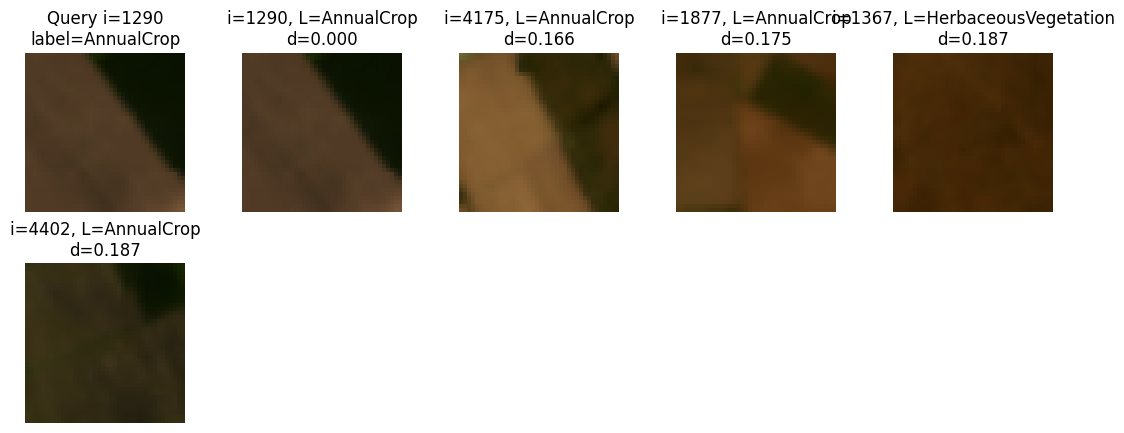

In [12]:
show_query_and_neighbors(1290, top_k=5)

[{'rank': 1, 'id': 'img_730', 'distance': 5.960464477539062e-07, 'label': 8, 'index': 730}, {'rank': 2, 'id': 'img_3212', 'distance': 0.22081124782562256, 'label': 8, 'index': 3212}, {'rank': 3, 'id': 'img_2806', 'distance': 0.23729127645492554, 'label': 8, 'index': 2806}, {'rank': 4, 'id': 'img_4520', 'distance': 0.23889899253845215, 'label': 8, 'index': 4520}, {'rank': 5, 'id': 'img_3732', 'distance': 0.2572094798088074, 'label': 8, 'index': 3732}]


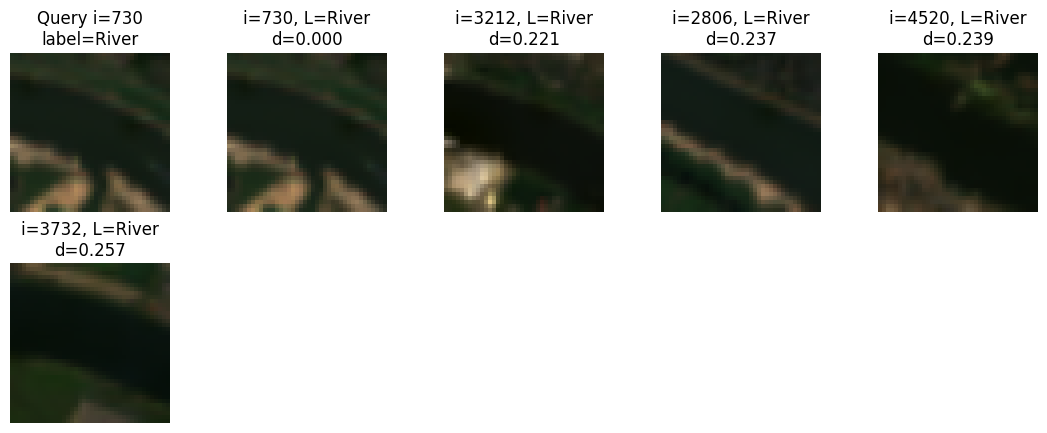

In [13]:
show_query_and_neighbors(730, top_k=5)

[{'rank': 1, 'id': 'img_5001', 'distance': 1.0728836059570312e-06, 'label': 9, 'index': 5001}, {'rank': 2, 'id': 'img_3881', 'distance': 0.00280606746673584, 'label': 9, 'index': 3881}, {'rank': 3, 'id': 'img_729', 'distance': 0.002893686294555664, 'label': 9, 'index': 729}, {'rank': 4, 'id': 'img_3226', 'distance': 0.0029290318489074707, 'label': 9, 'index': 3226}, {'rank': 5, 'id': 'img_1019', 'distance': 0.0029552578926086426, 'label': 9, 'index': 1019}]


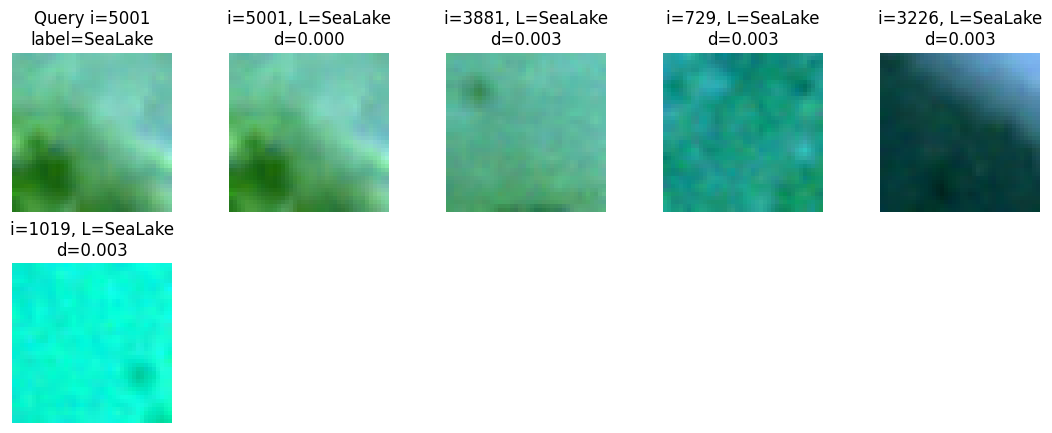

In [14]:
show_query_and_neighbors(5001, top_k=5)